In [1]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

In [27]:
%reload_ext autoreload
%autoreload 2
from projet_madi import *

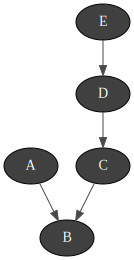

In [3]:
bn=gum.fastBN("A->B<-C<-D<-E")
fg=FactorGraph()
fg.build(bn)
gnb.showBN(bn)

In [7]:
ie = gum.LazyPropagation(bn)
ie.makeInference()
ie.posterior("D")

(gum::Potential<double>@0x55f8d2a648a0) <D:0> :: 0.585968 /<D:1> :: 0.414032

In [8]:
spi=TreeSumProductInference(fg) # Crée une instance d'inférence
spi.makeInference() # effectue les calculs de tous les messages
spi.posterior("D")

(gum::Potential<double>@0x55f8d2d87a90) <D:0> :: 0.585968 /<D:1> :: 0.414032

In [18]:
(bn.cpt(0).argmax())[0]['A']

0

In [42]:
bn.cpt(0)
import math

In [43]:
class TreeMaxSumInference:
    def __init__(self,f):
        self.fg = f
        self.most_likely_values = {}

    def makeInference(self):
        """ effectue les calculs de tous les messages """
        
        # Les noeuds à visiter, initialisés au feuilles de l'arbre
        to_visit = self.fg.leaves()
        # Les noeuds pour lequel les probalilités sont connues
        visited = []
        # La boîte aux lettres de chaque noeuds sous la forme d'un dictionnaire de listes de potentiels
        letterbox = {v.name() : [] for v in self.fg.variables}
        
        while len(to_visit) > 0:
            next_generation = []
            # Parcours des noeuds de la génération en cours
            for node in to_visit:
                # Si un noeud a suffisament de messages dans sa boîte aux lettres pour calculer ses probabilités
                if len(letterbox[node]) >= len(self.fg.edges[node].var_names) - 1:
                    visited.append(node)
                    # Calcul du potentiel du noeud
                    potential = self.fg.edges[node]
                    print("=====")
                    print(node)
                    print(potential)
                    print(letterbox[node])
                    for m in letterbox[node]:
                        potential = potential * m
                    print(potential)
                    potential = potential.margMaxIn(node)
                    print(potential)
                    
                    
                    # Mise à jour de la table des probabilités de chaque noeuds
                    self.most_likely_values[node] = potential
                    
                    # Parcours des voisins non explorés (ici ce seront les enfants du noeud)
                    neighbours = self.fg.neighbours(node)
                    for n in neighbours:
                        if not n in visited:
                            # Envoi du message du potentiel à l'enfant
                            letterbox[n].append(potential)
                            # Ajout de l'enfant dans les noeuds à explorer
                            if not n in next_generation:
                                next_generation.append(n)
                else:
                    # Si le noeud n'a pas suffisament de message, il faudra à nouveau l'exporer
                    next_generation.append(node)
            
            # Les noeuds à explorer sont actualisés comme ceux de la génération suivante 
            to_visit = next_generation


    def argmax(self):
        """ retourne un dictionnaire des valeurs des variables pour le MAP """
        return self.most_likely_values

In [44]:
mpi=TreeMaxSumInference(fg) #ou TreeMaxSumInference
mpi.makeInference()         # effectue les calculs de tous les messages
mpi.argmax()                # retourne un dictionnaire des valeurs des variables pour le MAP

TypeError: must be real number, not Potential